<center> <h1> AI for sound classification</h1> </center>
<center> <h3> Using image classification to classify environmental sounds</h3> </center>
<center> <h6>An approach by Simon B. and Ludwig H.</h6> </center>

---

## 1. Check Requirements


In [77]:
#!pip install librosa
#!pip install tqdm
#!conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

#!conda install -c anaconda ipykernel
#!python -m ipykernel install --user --name=base
#!python -m jupyterlab

#todo:
#confusion matrix
#loss

In [ ]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
import pickle
import IPython

## 2. Get Data
---

In [ ]:
!unzip -qq master.zip

In [10]:
%cd ESC-50-master

C:\Users\simon\Desktop\Seminar\Sound-Classification-for-Predictive-Maintenance\ESC-50-master


In [11]:
df = pd.read_csv('meta/esc50.csv')

## 3. Show Data
---

In [12]:
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## 4. Datapreprocessing
---

In [14]:
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [15]:
wav, sr = librosa.load('audio/1-100032-A-0.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds


### 4.1 Define tranfromation functions

In [19]:
# Transforms .wav data into spectograms
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

# Transforms a spectorgram into an image
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

### 4.2 Define Pytorch Dataset Class

In [20]:
class ESC50Data(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base,row[in_col])
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

### 4.3 Test tranfromation functions

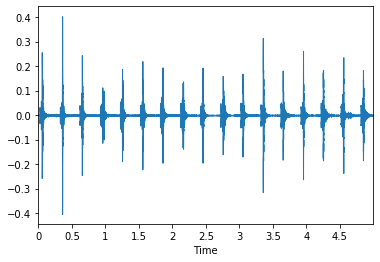

In [24]:
# Show raw data:
filename = valid[valid['category']=='clock_tick'].iloc[0]['filename']
wav, sr = librosa.load('audio/'+filename, sr=None)
librosa.display.waveplot(wav, sr)

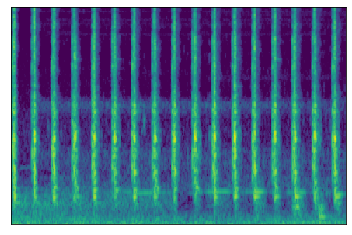

In [25]:
#show preprocesst data
librosa.display.specshow(spec_to_image(get_melspectrogram_db('audio/'+filename, sr)), cmap='viridis')

### 4.4 Create Pytorch Datasets

In [26]:
train_data = ESC50Data('audio', train, 'filename', 'category')

100%|██████████████████████████████████████████████████████████████████████████████| 1600/1600 [00:25<00:00, 62.99it/s]


In [27]:
valid_data = ESC50Data('audio', valid, 'filename', 'category')

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:06<00:00, 65.68it/s]


In [28]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

## 5. Setup Training
----

In [30]:
# Select training device
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
print(device)

cuda:0


In [75]:
# define neural network
from torchvision.models import resnet34
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512,50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

In [70]:
# set Hyperparameter
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]

In [41]:
# define learningrate
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer

In [42]:
# define model traing
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

## 6. Start Training
----

In [71]:
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 0.4084914466738701
Epoch - 1 Valid-Loss : 1.600579915046692 Valid-Accuracy : 0.625


  2%|█▋                                                                                 | 1/50 [00:15<12:40, 15.53s/it]

Epoch - 2 Train-Loss : 0.24576605491340162
Epoch - 2 Valid-Loss : 1.2317974269390106 Valid-Accuracy : 0.6875


  4%|███▎                                                                               | 2/50 [00:31<12:25, 15.54s/it]

Epoch - 3 Train-Loss : 0.2803566553816199
Epoch - 3 Valid-Loss : 1.2689597141742706 Valid-Accuracy : 0.6725


  6%|████▉                                                                              | 3/50 [00:46<12:11, 15.56s/it]

Epoch - 4 Train-Loss : 0.17789780171588063
Epoch - 4 Valid-Loss : 1.428678948879242 Valid-Accuracy : 0.65


  8%|██████▋                                                                            | 4/50 [01:02<11:55, 15.55s/it]

Epoch - 5 Train-Loss : 0.21659487390890717
Epoch - 5 Valid-Loss : 1.221739604473114 Valid-Accuracy : 0.675


 10%|████████▎                                                                          | 5/50 [01:17<11:39, 15.53s/it]

Epoch - 6 Train-Loss : 0.148554961187765
Epoch - 6 Valid-Loss : 1.3023623275756835 Valid-Accuracy : 0.705


 12%|█████████▉                                                                         | 6/50 [01:33<11:23, 15.53s/it]

Epoch - 7 Train-Loss : 0.10356473058462143
Epoch - 7 Valid-Loss : 1.235336136817932 Valid-Accuracy : 0.71


 14%|███████████▌                                                                       | 7/50 [01:48<11:07, 15.53s/it]

Epoch - 8 Train-Loss : 0.1392954885214567
Epoch - 8 Valid-Loss : 1.1906847721338272 Valid-Accuracy : 0.6775


 16%|█████████████▎                                                                     | 8/50 [02:04<10:52, 15.54s/it]

Epoch - 9 Train-Loss : 0.06411477104527875
Epoch - 9 Valid-Loss : 1.1900323182344437 Valid-Accuracy : 0.715


 18%|██████████████▉                                                                    | 9/50 [02:19<10:37, 15.55s/it]

Changed learning rate to 2e-05
Epoch - 10 Train-Loss : 0.03458272356074303
Epoch - 10 Valid-Loss : 0.9456177234649659 Valid-Accuracy : 0.76


 20%|████████████████▍                                                                 | 10/50 [02:35<10:23, 15.58s/it]

Epoch - 11 Train-Loss : 0.01579496873426251
Epoch - 11 Valid-Loss : 0.9032567238807678 Valid-Accuracy : 0.7725


 22%|██████████████████                                                                | 11/50 [02:51<10:09, 15.62s/it]

Epoch - 12 Train-Loss : 0.015516848750412465
Epoch - 12 Valid-Loss : 0.9161613032221794 Valid-Accuracy : 0.76


 24%|███████████████████▋                                                              | 12/50 [03:06<09:53, 15.61s/it]

Epoch - 13 Train-Loss : 0.016235092487186194
Epoch - 13 Valid-Loss : 0.884763216972351 Valid-Accuracy : 0.7825


 26%|█████████████████████▎                                                            | 13/50 [03:22<09:38, 15.63s/it]

Epoch - 14 Train-Loss : 0.01122723992622923
Epoch - 14 Valid-Loss : 0.8692685532569885 Valid-Accuracy : 0.78


 28%|██████████████████████▉                                                           | 14/50 [03:38<09:22, 15.64s/it]

Epoch - 15 Train-Loss : 0.008854249075520784
Epoch - 15 Valid-Loss : 0.8812999191880226 Valid-Accuracy : 0.775


 30%|████████████████████████▌                                                         | 15/50 [03:53<09:07, 15.64s/it]

Epoch - 16 Train-Loss : 0.008469381988979875
Epoch - 16 Valid-Loss : 0.8806126570701599 Valid-Accuracy : 0.78


 32%|██████████████████████████▏                                                       | 16/50 [04:09<08:53, 15.68s/it]

Epoch - 17 Train-Loss : 0.00745281939744018
Epoch - 17 Valid-Loss : 0.8664047861099243 Valid-Accuracy : 0.795


 34%|███████████████████████████▉                                                      | 17/50 [04:25<08:37, 15.68s/it]

Epoch - 18 Train-Loss : 0.006177458127494901
Epoch - 18 Valid-Loss : 0.8627145056426525 Valid-Accuracy : 0.785


 36%|█████████████████████████████▌                                                    | 18/50 [04:41<08:23, 15.72s/it]

Epoch - 19 Train-Loss : 0.005906129698851146
Epoch - 19 Valid-Loss : 0.8677783459424973 Valid-Accuracy : 0.7825


 38%|███████████████████████████████▏                                                  | 19/50 [04:56<08:08, 15.75s/it]

Changed learning rate to 2e-06
Epoch - 20 Train-Loss : 0.006892615060205571
Epoch - 20 Valid-Loss : 0.9052417546510696 Valid-Accuracy : 0.79


 40%|████████████████████████████████▊                                                 | 20/50 [05:12<07:52, 15.76s/it]

Epoch - 21 Train-Loss : 0.007863339204341173
Epoch - 21 Valid-Loss : 0.903464033305645 Valid-Accuracy : 0.79


 42%|██████████████████████████████████▍                                               | 21/50 [05:28<07:37, 15.76s/it]

Epoch - 22 Train-Loss : 0.006995132207521237
Epoch - 22 Valid-Loss : 0.8631836831569671 Valid-Accuracy : 0.7875


 44%|████████████████████████████████████                                              | 22/50 [05:44<07:21, 15.78s/it]

Epoch - 23 Train-Loss : 0.00564295710704755
Epoch - 23 Valid-Loss : 0.8750714433193206 Valid-Accuracy : 0.8


 46%|█████████████████████████████████████▋                                            | 23/50 [06:00<07:06, 15.78s/it]

Epoch - 24 Train-Loss : 0.006610558037937153
Epoch - 24 Valid-Loss : 0.8495762330293656 Valid-Accuracy : 0.79


 48%|███████████████████████████████████████▎                                          | 24/50 [06:15<06:50, 15.79s/it]

Epoch - 25 Train-Loss : 0.009215194449061527
Epoch - 25 Valid-Loss : 0.8693171995878219 Valid-Accuracy : 0.78


 50%|█████████████████████████████████████████                                         | 25/50 [06:31<06:35, 15.81s/it]

Epoch - 26 Train-Loss : 0.005350516453036107
Epoch - 26 Valid-Loss : 0.8726585936546326 Valid-Accuracy : 0.8025


 52%|██████████████████████████████████████████▋                                       | 26/50 [06:47<06:19, 15.80s/it]

Epoch - 27 Train-Loss : 0.005244348169653677
Epoch - 27 Valid-Loss : 0.8681320512294769 Valid-Accuracy : 0.7825


 54%|████████████████████████████████████████████▎                                     | 27/50 [07:03<06:03, 15.79s/it]

Epoch - 28 Train-Loss : 0.005387552715837955
Epoch - 28 Valid-Loss : 0.8855735182762146 Valid-Accuracy : 0.795


 56%|█████████████████████████████████████████████▉                                    | 28/50 [07:19<05:48, 15.82s/it]

Epoch - 29 Train-Loss : 0.006476723718224093
Epoch - 29 Valid-Loss : 0.8425056993961334 Valid-Accuracy : 0.7975


 58%|███████████████████████████████████████████████▌                                  | 29/50 [07:35<05:32, 15.84s/it]

Changed learning rate to 2.0000000000000002e-07
Epoch - 30 Train-Loss : 0.006281225652783178
Epoch - 30 Valid-Loss : 0.8758496344089508 Valid-Accuracy : 0.785


 60%|█████████████████████████████████████████████████▏                                | 30/50 [07:50<05:16, 15.85s/it]

Epoch - 31 Train-Loss : 0.004154938009451143
Epoch - 31 Valid-Loss : 0.8541106036305428 Valid-Accuracy : 0.7875


 62%|██████████████████████████████████████████████████▊                               | 31/50 [08:06<05:00, 15.84s/it]

Epoch - 32 Train-Loss : 0.006688909387448803
Epoch - 32 Valid-Loss : 0.8741227757930755 Valid-Accuracy : 0.7925


 64%|████████████████████████████████████████████████████▍                             | 32/50 [08:22<04:44, 15.83s/it]

Epoch - 33 Train-Loss : 0.005932632763287984
Epoch - 33 Valid-Loss : 0.856653299331665 Valid-Accuracy : 0.8


 66%|██████████████████████████████████████████████████████                            | 33/50 [08:38<04:28, 15.82s/it]

Epoch - 34 Train-Loss : 0.00494340957782697
Epoch - 34 Valid-Loss : 0.854776246547699 Valid-Accuracy : 0.8


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [08:54<04:13, 15.82s/it]

Epoch - 35 Train-Loss : 0.005282721039839089
Epoch - 35 Valid-Loss : 0.8635274505615235 Valid-Accuracy : 0.8025


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [09:10<03:57, 15.84s/it]

Epoch - 36 Train-Loss : 0.005284188467194326
Epoch - 36 Valid-Loss : 0.8682657803595066 Valid-Accuracy : 0.79


 72%|███████████████████████████████████████████████████████████                       | 36/50 [09:25<03:42, 15.86s/it]

Epoch - 37 Train-Loss : 0.005129456512513571
Epoch - 37 Valid-Loss : 0.8772405302524566 Valid-Accuracy : 0.7975


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [09:41<03:26, 15.86s/it]

Epoch - 38 Train-Loss : 0.005530849458300509
Epoch - 38 Valid-Loss : 0.852772809267044 Valid-Accuracy : 0.7925


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [09:57<03:10, 15.85s/it]

Epoch - 39 Train-Loss : 0.004126658913155552
Epoch - 39 Valid-Loss : 0.8558336681127549 Valid-Accuracy : 0.8025


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [10:13<02:54, 15.87s/it]

Changed learning rate to 2e-08
Epoch - 40 Train-Loss : 0.003811765066930093
Epoch - 40 Valid-Loss : 0.8797745114564895 Valid-Accuracy : 0.79


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [10:29<02:38, 15.87s/it]

Epoch - 41 Train-Loss : 0.005421366798691452
Epoch - 41 Valid-Loss : 0.8841011649370194 Valid-Accuracy : 0.8025


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [10:45<02:23, 15.91s/it]

Epoch - 42 Train-Loss : 0.0070079688922851345
Epoch - 42 Valid-Loss : 0.8509538546204567 Valid-Accuracy : 0.8


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [11:01<02:07, 15.91s/it]

Epoch - 43 Train-Loss : 0.005136778275482356
Epoch - 43 Valid-Loss : 0.8599177807569504 Valid-Accuracy : 0.7925


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [11:17<01:51, 15.90s/it]

Epoch - 44 Train-Loss : 0.005185731089441105
Epoch - 44 Valid-Loss : 0.872229306101799 Valid-Accuracy : 0.78


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [11:33<01:35, 15.88s/it]

Epoch - 45 Train-Loss : 0.005053081318619661
Epoch - 45 Valid-Loss : 0.8578537481278181 Valid-Accuracy : 0.7925


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [11:48<01:19, 15.88s/it]

Epoch - 46 Train-Loss : 0.004698655675165355
Epoch - 46 Valid-Loss : 0.8564126551151275 Valid-Accuracy : 0.7975


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [12:04<01:03, 15.88s/it]

Epoch - 47 Train-Loss : 0.006140459530288353
Epoch - 47 Valid-Loss : 0.8820991015434265 Valid-Accuracy : 0.785


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [12:20<00:47, 15.89s/it]

Epoch - 48 Train-Loss : 0.00467327723861672
Epoch - 48 Valid-Loss : 0.8403702366352082 Valid-Accuracy : 0.8


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [12:36<00:31, 15.89s/it]

Epoch - 49 Train-Loss : 0.005103300746995955
Epoch - 49 Valid-Loss : 0.8505680352449417 Valid-Accuracy : 0.79


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [12:52<00:15, 15.87s/it]

Changed learning rate to 2e-09
Epoch - 50 Train-Loss : 0.006416054808069021
Epoch - 50 Valid-Loss : 0.8507614576816559 Valid-Accuracy : 0.7975


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:08<00:00, 15.88s/it]


## 7. Show traing results
---

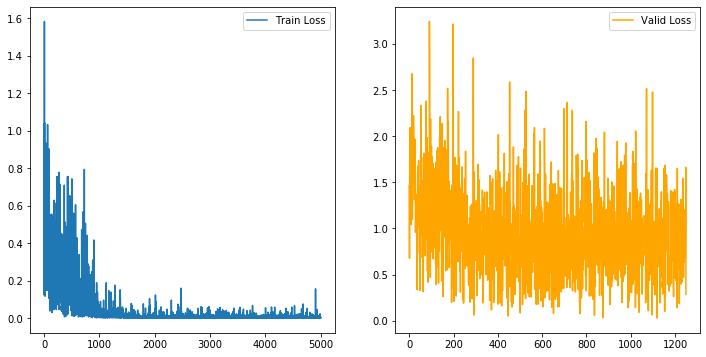

In [72]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [66]:
with open('indtocat.pkl','rb') as f:
  indtocat = pickle.load(f)
filename='audio/1-137-A-32.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print("Model Prediction:" + indtocat[ind])
print("Actually:")
IPython.display.display(IPython.display.Audio(filename=filename))

Model Prediction:keyboard_typing
Actually:


In [73]:
with open('indtocat.pkl','rb') as f:
  indtocat = pickle.load(f)
filename='audio/5-180229-A-27.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print("Model Prediction:" + indtocat[ind])
print("Actually:")
IPython.display.display(IPython.display.Audio(filename=filename))

Model Prediction:brushing_teeth
Actually:


## 8. Save Model
---

In [50]:
#saves model
with open('esc50resnet.pth','wb') as f:
  torch.save(resnet_model, f)

In [51]:
#saved the tran data
with open('indtocat.pkl','wb') as f:
  pickle.dump(train_data.i2c, f)

## 8. Show Model
---

In [76]:
print(resnet_model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  